In [1]:
import os
os.chdir(os.getenv("WORKINGDIR"))
from copy import deepcopy
import numpy as np
from numpy.typing import ArrayLike
import pandas as pd
from astropy.io import fits
import matplotlib.pyplot as plt
from skipper_image_analysis.utils import (
    plot_ccd_image, mask_baseline_error, correct_overscan, get_rowcol_ovserscan
)
from scipy.optimize import curve_fit

# Matplotlib settings
%config InlineBackend.figure_format = "retina"  # For high dpi figures in notebook
plt.rcParams["font.family"] = "serif"
plt.rcParams["mathtext.fontset"] = "cm"
plt.rcParams["figure.dpi"] = 120
plt.rcParams["legend.fontsize"] = "medium"
plt.rcParams["axes.labelsize"] = "large"

## Load an Image

In [2]:
data_dir = 'skipper_data/TRAPS/29JUN2023'
# data_dir = 'skipper_data/TRAPS/03JUL2023'
# data_dir = 'skipper_data/TRAPS/13JUL2023'

files_in_dir = os.listdir(data_dir)
exposure = 1800 # s: exposure time of the image
file_names = []
for name in files_in_dir:
    if f"EXPOSURE{exposure}" in name:
        file_names.append(name)
print(f"Files in {data_dir} with {exposure} s of exposure time:", *file_names, sep="\n")

# Select and Load an Image
image_num = 0
test_image = fits.open(f'{data_dir}/{file_names[image_num]}')
print(f"\nLoaded {file_names[image_num]}\n")
# Mask Rows with an error in the Baseline Calculation
# for frame in range(4):
#     test_image[frame].data = mask_baseline_error(test_image[frame].data)
# print("Masked outlier rows from data.")

Files in skipper_data/TRAPS/29JUN2023 with 1800 s of exposure time:
proc_skp_no_cover_standard_NSAMP25_NROW829_NCOL336_EXPOSURE1800_img87.fits
proc_skp_no_cover_standard_NSAMP25_NROW829_NCOL336_EXPOSURE1800_img63.fits
proc_skp_no_cover_standard_NSAMP25_NROW829_NCOL336_EXPOSURE1800_img51.fits
proc_skp_no_cover_standard_NSAMP25_NROW829_NCOL336_EXPOSURE1800_img75.fits
proc_skp_no_cover_standard_NSAMP25_NROW829_NCOL336_EXPOSURE1800_img15.fits
proc_skp_no_cover_standard_NSAMP25_NROW829_NCOL336_EXPOSURE1800_img39.fits

Loaded proc_skp_no_cover_standard_NSAMP25_NROW829_NCOL336_EXPOSURE1800_img87.fits



In [5]:
data_dir = 'skipper_data/TRAPS/15SEP2023'
# data_dir = 'skipper_data/TRAPS/27OCT2023'
# data_dir = "skipper_data/TRAPS"
# data_dir = "skipper_data/TRAPS/10NOV2023_140K/"
files_in_dir = os.listdir(data_dir)
valid_formats = ["fits",]  # "fz"]
files_in_dir = [f for f in files_in_dir if f.rsplit(".")[-1] in valid_formats]

print(".fits Files in Directory:", *files_in_dir, sep="\n")
i = 0
test_image = fits.open(f'{data_dir}/{files_in_dir[i]}')
print(f"\nLoaded {files_in_dir[i]}\n")


.fits Files in Directory:
proc_skp_no_cover_shutter_calibration_NSAMP400_NROW20_NCOL336_EXPOSURE_img4.fits

Loaded proc_skp_no_cover_shutter_calibration_NSAMP400_NROW20_NCOL336_EXPOSURE_img4.fits



In [13]:
sgn_files = {
    "0film": {
        0.10: "proc_skp_shut_open_oled1row_sgn_NSAMP5_NROW879_NCOL336_EXPOSURE0.1_img20.fits",
        0.25: "proc_skp_shut_open_oled1row_sgn_NSAMP5_NROW879_NCOL336_EXPOSURE0.25_img23.fits",
        0.50: "proc_skp_shut_open_oled1row_sgn_NSAMP5_NROW879_NCOL336_EXPOSURE0.5_img26.fits",
        0.75: "proc_skp_shut_open_oled1row_sgn_NSAMP5_NROW879_NCOL336_EXPOSURE0.75_img29.fits",
        1.00: "proc_skp_shut_open_oled1row_sgn_NSAMP5_NROW879_NCOL336_EXPOSURE1.0_img32.fits",
        1.25: "proc_skp_shut_open_oled1row_sgn_NSAMP5_NROW879_NCOL336_EXPOSURE1.25_img35.fits",
    },
    "1film": {
        0.25: "proc_skp_shut_open_oled1row_1film_sgn_NSAMP5_NROW879_NCOL336_EXPOSURE0.25_img7.fits",
        0.75: "proc_skp_shut_open_oled1row_1film_sgn_NSAMP5_NROW879_NCOL336_EXPOSURE0.75_img10.fits",
        2.50: "proc_skp_shut_open_oled1row_1film_sgn_NSAMP5_NROW879_NCOL336_EXPOSURE2.5_img28.fits",
        5.00: "proc_skp_shut_open_oled1row_1film_sgn_NSAMP5_NROW879_NCOL336_EXPOSURE5.0_img31.fits",
    },
    "2film": {
        1.00: "proc_skp_shut_open_oled1row_2film_sgn_NSAMP5_NROW879_NCOL336_EXPOSURE1.0_img13.fits",
        2.00: "proc_skp_shut_open_oled1row_2film_sgn_NSAMP5_NROW879_NCOL336_EXPOSURE2.0_img16.fits",
        4.00: "proc_skp_shut_open_oled1row_2film_sgn_NSAMP5_NROW879_NCOL336_EXPOSURE4.0_img19.fits",
        8.00: "proc_skp_shut_open_oled1row_2film_sgn_NSAMP5_NROW879_NCOL336_EXPOSURE8.0_img22.fits",
        16.0: "proc_skp_shut_open_oled1row_2film_sgn_NSAMP5_NROW879_NCOL336_EXPOSURE16.0_img25.fits",
    },
}
bkg_files = {
    "0film": {
        0.10: 'proc_skp_shut_open_oled1row_bkg_NSAMP5_NROW879_NCOL336_EXPOSURE0.1_img19.fits',
        0.25: 'proc_skp_shut_open_oled1row_bkg_NSAMP5_NROW879_NCOL336_EXPOSURE0.25_img22.fits',
        0.50: 'proc_skp_shut_open_oled1row_bkg_NSAMP5_NROW879_NCOL336_EXPOSURE0.5_img25.fits',
        0.75: 'proc_skp_shut_open_oled1row_bkg_NSAMP5_NROW879_NCOL336_EXPOSURE0.75_img28.fits',
        1.00: 'proc_skp_shut_open_oled1row_bkg_NSAMP5_NROW879_NCOL336_EXPOSURE1.0_img31.fits',
        1.25: 'proc_skp_shut_open_oled1row_bkg_NSAMP5_NROW879_NCOL336_EXPOSURE1.25_img34.fits',
    },
    "1film": {
        0.25: 'proc_skp_shut_open_oled1row_1film_bkg_NSAMP5_NROW879_NCOL336_EXPOSURE0.25_img6.fits',
        0.75: 'proc_skp_shut_open_oled1row_1film_bkg_NSAMP5_NROW879_NCOL336_EXPOSURE0.75_img9.fits',
        2.50: "proc_skp_shut_open_oled1row_1film_bkg_NSAMP5_NROW879_NCOL336_EXPOSURE2.5_img27.fits",
        5.00: "proc_skp_shut_open_oled1row_1film_bkg_NSAMP5_NROW879_NCOL336_EXPOSURE5.0_img30.fits",
    },
    "2film": {
        1.00: 'proc_skp_shut_open_oled1row_2film_bkg_NSAMP5_NROW879_NCOL336_EXPOSURE1.0_img12.fits',
        2.00: 'proc_skp_shut_open_oled1row_2film_bkg_NSAMP5_NROW879_NCOL336_EXPOSURE2.0_img15.fits',
        4.00: 'proc_skp_shut_open_oled1row_2film_bkg_NSAMP5_NROW879_NCOL336_EXPOSURE4.0_img18.fits',
        8.00: 'proc_skp_shut_open_oled1row_2film_bkg_NSAMP5_NROW879_NCOL336_EXPOSURE8.0_img21.fits',
        16.0: 'proc_skp_shut_open_oled1row_2film_bkg_NSAMP5_NROW879_NCOL336_EXPOSURE16.0_img24.fits',
    },
}

e_time = 5.00
nfilms = 1
if nfilms == 0:
    data_dir = 'skipper_data/TRAPS/19OCT2023'
elif nfilms in [1, 2]:
    data_dir = 'skipper_data/TRAPS/26OCT2023'
test_image = fits.open(f'{data_dir}/{sgn_files[f"{nfilms}film"][e_time]}')  # Signal (w/ Oled On)
# test_image = fits.open(f'{data_dir}/{bkg_files[e_time]}')  # Background (w/ Oled Off)
print(f'\nLoaded {sgn_files[f"{nfilms}film"][e_time]}\n')


Loaded proc_skp_shut_open_oled1row_1film_sgn_NSAMP5_NROW879_NCOL336_EXPOSURE5.0_img31.fits



## Display Image

/home/agustin/Documents/FCEN/2023_1er_Cuatrimestre/Laboratorio_6&7/LAMBDA_Hub/lambda_env/lib/python3.11/site-packages/numpy/core/fromnumeric.py:3464: RuntimeWarning: Mean of empty slice.
  return _methods._mean(a, axis=axis, dtype=dtype,
/home/agustin/Documents/FCEN/2023_1er_Cuatrimestre/Laboratorio_6&7/LAMBDA_Hub/lambda_env/lib/python3.11/site-packages/numpy/core/_methods.py:184: RuntimeWarning: invalid value encountered in divide
  ret = um.true_divide(


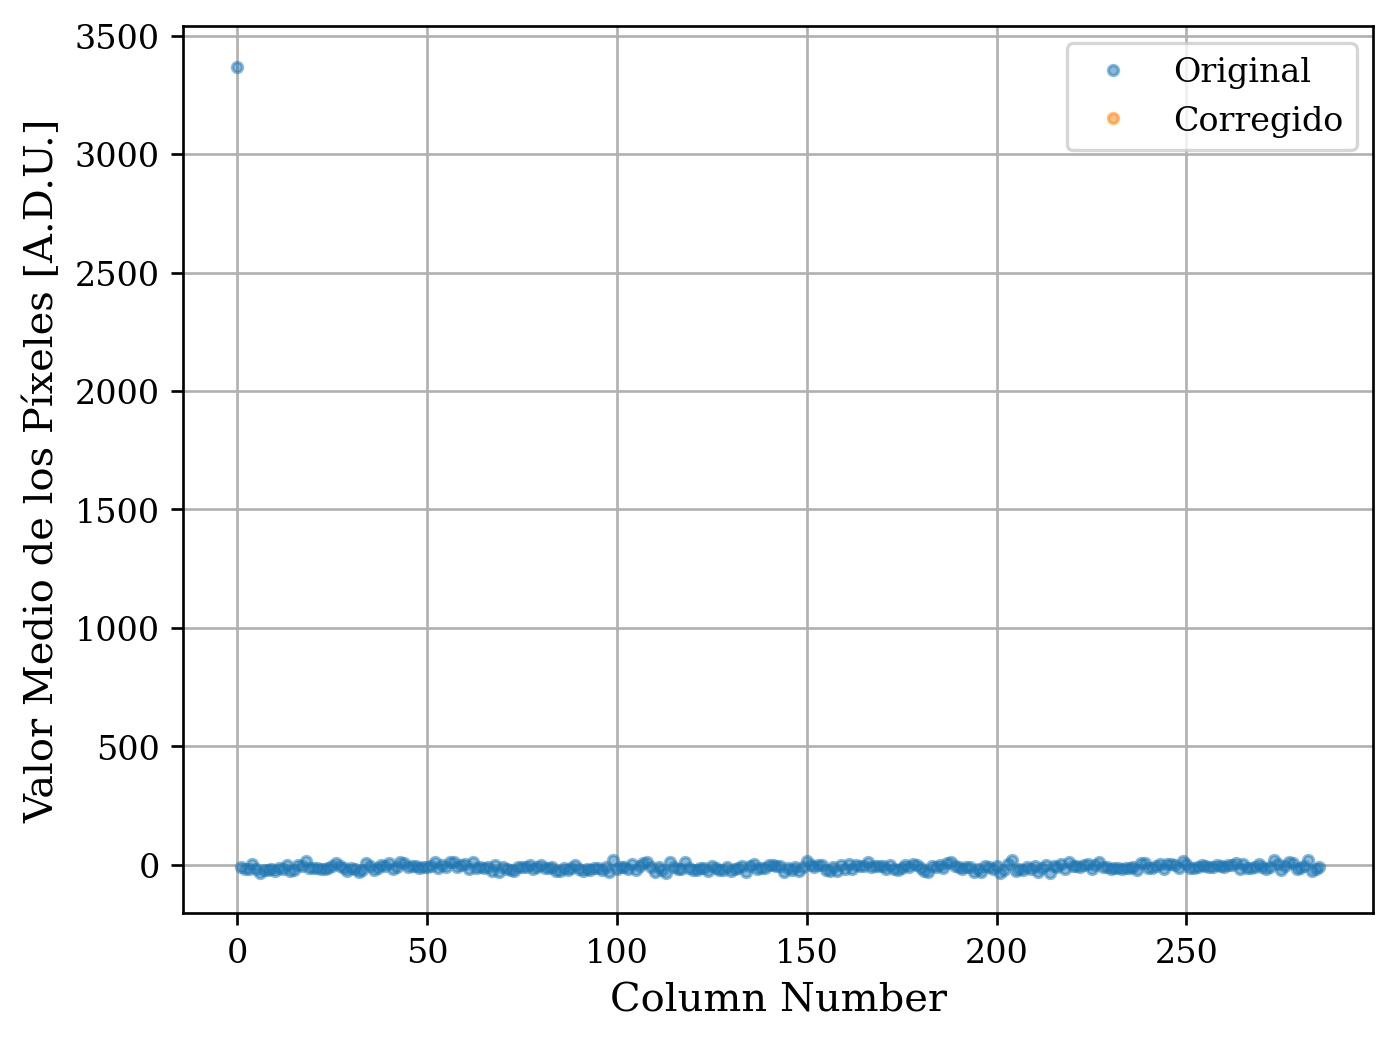

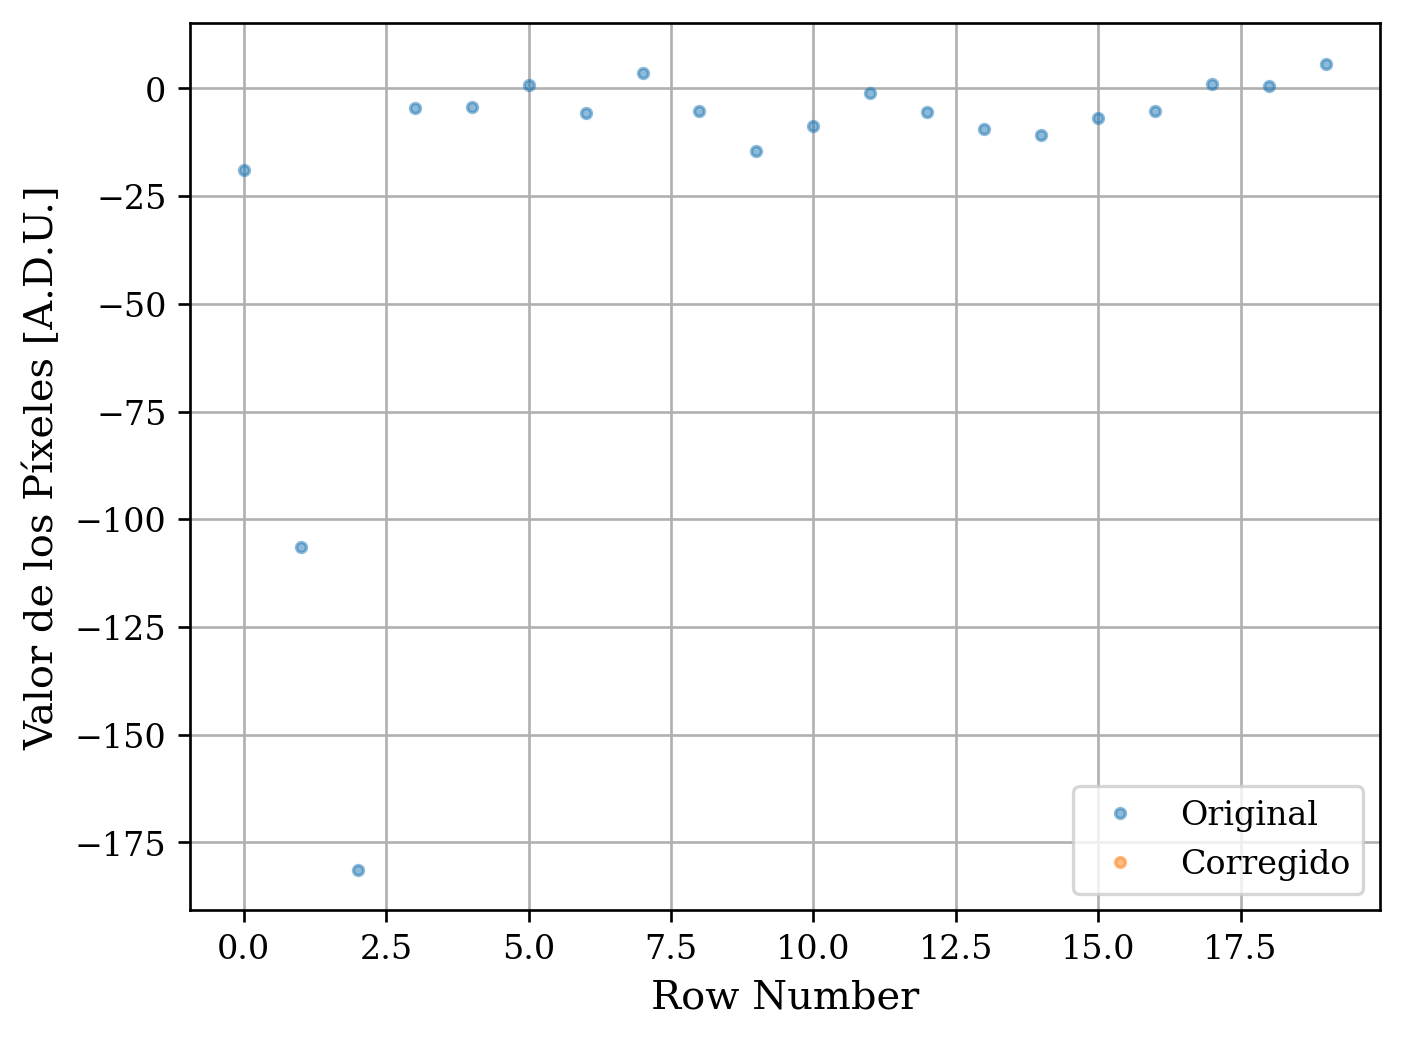

In [4]:
PRESCAN_PIX = 8
frame_id = 0
test_frame = test_image[frame_id].data

fixed_image = correct_overscan(deepcopy(test_image))
fixed_frame = fixed_image[frame_id].data

r_overscan, c_overscan = get_rowcol_ovserscan(test_image)

# plt.plot(test_frame.mean(axis=0), '.', alpha=0.5)
# plt.plot(fixed_frame.mean(axis=0), '.', alpha=0.5)
plt.plot(np.median(test_frame[:-r_overscan, PRESCAN_PIX:-c_overscan], axis=0), '.', alpha=0.5, label="Original")
plt.plot(np.median(fixed_frame[:-r_overscan, PRESCAN_PIX:-c_overscan], axis=0), '.', alpha=0.5, label="Corregido")
plt.grid()
plt.legend()
plt.xlabel("Column Number")
plt.ylabel("Valor Medio de los Píxeles [A.D.U.]")
plt.show()

# plt.plot(test_frame.mean(axis=1), '.', alpha=0.5)
# plt.plot(fixed_frame.mean(axis=1), '.', alpha=0.5)
plt.plot(np.median(test_frame[:-r_overscan, PRESCAN_PIX:-c_overscan], axis=1), '.', alpha=0.5, label="Original")
plt.plot(np.median(fixed_frame[:-r_overscan, PRESCAN_PIX:-c_overscan], axis=1), '.', alpha=0.5, label="Corregido")
plt.grid()
plt.legend()
plt.xlabel("Row Number")
plt.ylabel("Valor de los Píxeles [A.D.U.]")
plt.show()

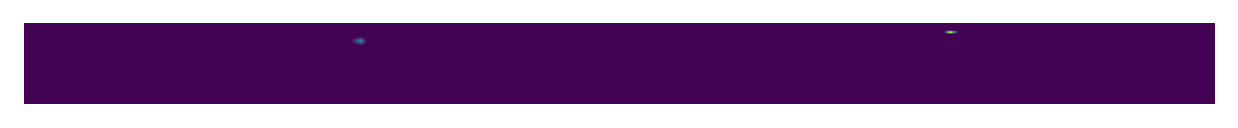

In [6]:
# Plot the image
ganancia = {
    0: 210,
    1: 232,
    2: 207,
    3: 159
}
# plot_image = deepcopy(fixed_image)
plot_image = deepcopy(test_image)
if True:  # Plot by e⁻ instead of A.D.U.
    for i, frame in enumerate(plot_image):
        frame.data /= ganancia[i]

fig, ax, imshow_cmap = plot_ccd_image(
    plot_image,
    remove_overscan=True,
    orientation="vertical",
    cmap="viridis",
    # value_map=lambda x: x*(x < 2000) + 2000*(x > 2000),
    # value_map=lambda x: np.log(np.abs(x) + 1),
    value_map=lambda x: x,
)
# plt.colorbar(imshow_cmap, label="ADUs", ax=ax)
plt.show()
# fig.savefig("skipper_data/figuras_informe/skipper_example_image.png")

## Display Distribution

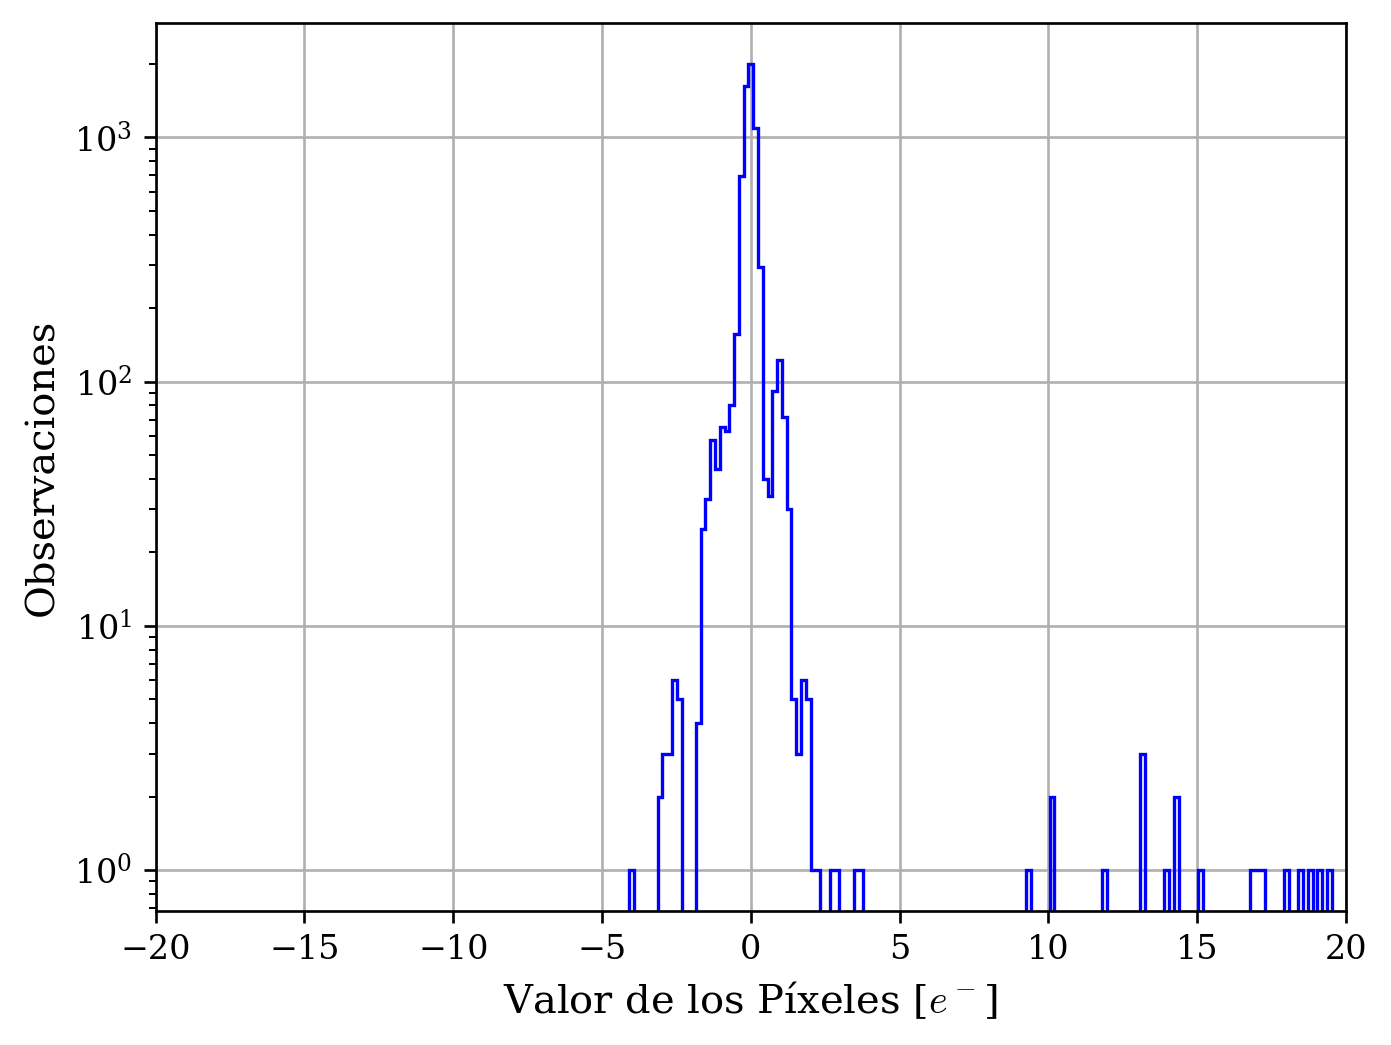

In [10]:
min_val = -20  # e⁻
tope = 20  # e⁻
n_bins = 250

ganancia = {
    0: 210,
    1: 232,
    2: 207,
    3: 159
}

#test_data = np.concatenate([fixed_image[frame].data.flatten() for frame in range(4)])
frame_idx = 0
test_data = test_image[frame_idx].data.flatten()
fig, ax = plt.subplots(1, 1)
if min_val is None:
    min_val = np.nanmin(test_data)
if tope is None:
    tope = np.nanmax(test_data)
cuentas, valores, _ = ax.hist(
    test_data[
        (test_data > min_val * ganancia[frame_idx])
        & (test_data < tope * ganancia[frame_idx])
    ] / ganancia[frame_idx],
    bins=np.linspace(min_val, tope, n_bins),
    histtype="step",
    color="blue",
    
)
ax.grid(True)
ax.set_yscale("log")
# ax.set_yticks(10**np.arange(5))
ax.set_xlim(min_val, tope)
ax.set_xlabel("Valor de los Píxeles [$e^-$]")
ax.set_ylabel("Observaciones")
plt.show()

# Cálculo de ganancia

Parámetros del ajuste:
A0 = ( 5179 ±  5e+01)
A1 = (  1   ±  3e+01)
g  = (-829  ±  6e+03) A.D.U.
μ0 = (-7.4  ±   1  ) A.D.U.
σ  = ( 56.7 ±  0.8 ) A.D.U.



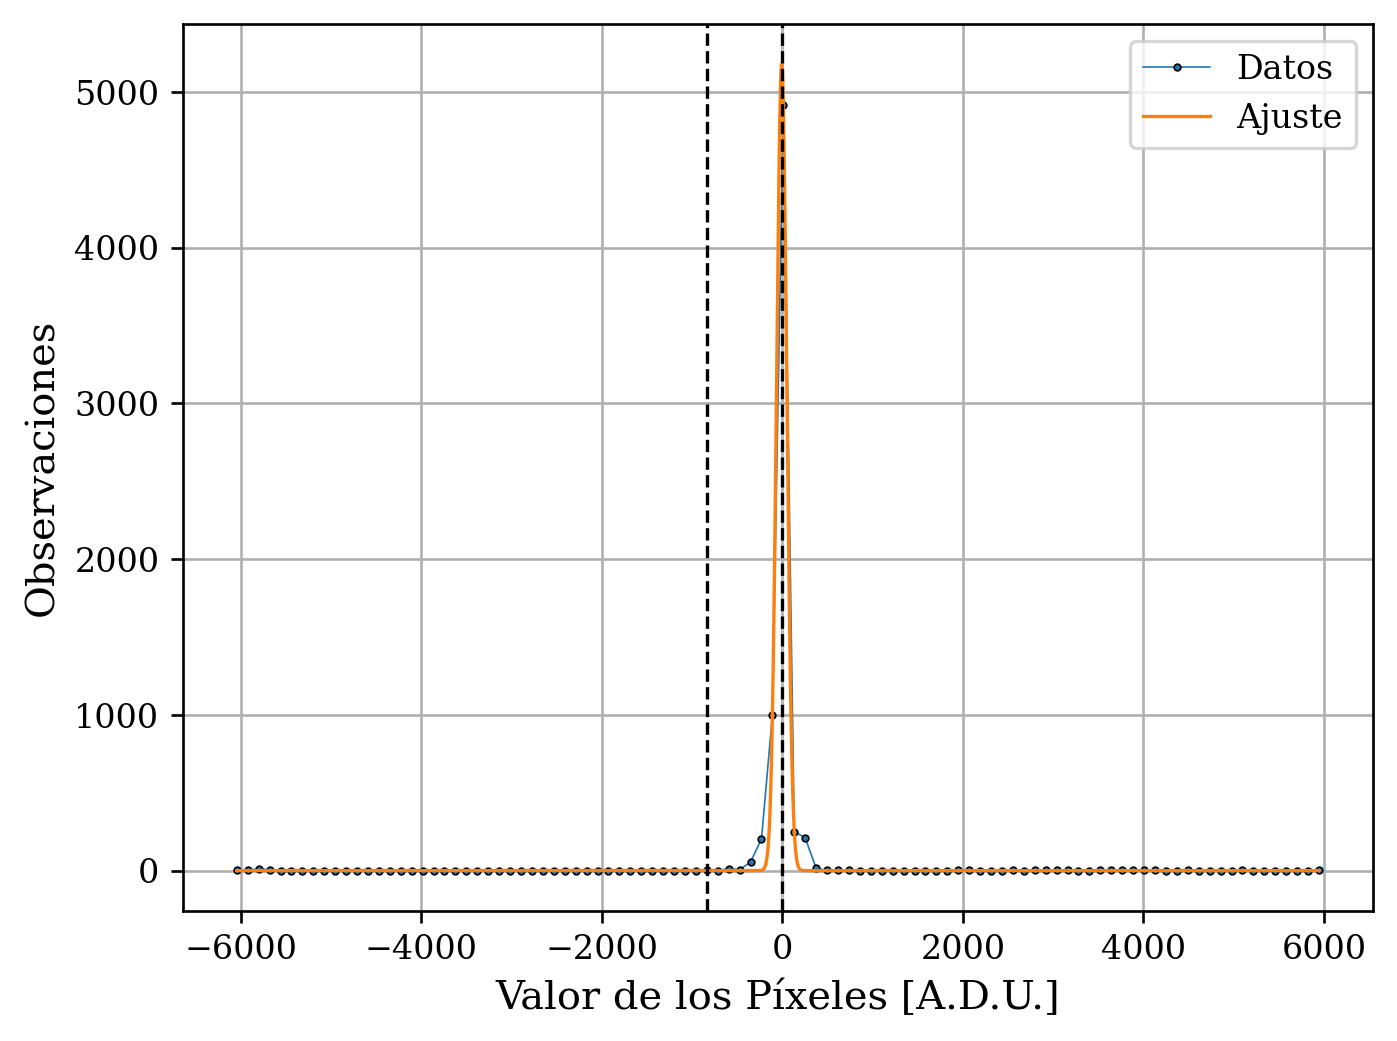

In [13]:
def suma_gaussianas(
    x: ArrayLike,
    A0: float,
    A1: float,
    g: float,
    mu: float,
    sigma: float,
) -> ArrayLike:
    return (A0 * np.exp(-0.5*((x - mu)/(sigma))**2)
            + A1 * np.exp(-0.5*((x - mu - g)/(sigma))**2))

test_data = test_image[frame_idx].data.flatten()
cuentas, valores = np.histogram(
    test_data[
        (test_data < -test_data.min())
    ],
    bins=100,
)
valores_centrados = valores[:-1] + np.diff(valores)/2
popt, pcov = curve_fit(
    suma_gaussianas, valores_centrados, cuentas, p0=[350, 25, 200, 0, 50]
)
perr = np.sqrt(np.diag(pcov))
print(
    f"Parámetros del ajuste:\n"
    f"A0 = ({popt[0]: ^ 5.0f} ± {perr[0]: ^ 5.1g})\n"
    f"A1 = ({popt[1]: ^ 5.0f} ± {perr[1]: ^ 5.1g})\n"
    f"g  = ({popt[2]: ^ 5.0f} ± {perr[2]: ^ 5.1g}) A.D.U.\n"
    f"μ0 = ({popt[3]: ^ 5.1f} ± {perr[3]: ^ 5.1g}) A.D.U.\n"
    f"σ  = ({popt[4]: ^ 5.1f} ± {perr[4]: ^ 5.1g}) A.D.U.\n"
)

adu = np.linspace(valores_centrados[0], valores_centrados[-1], 10_000)
fig, ax = plt.subplots(1, 1)
ax.plot(valores_centrados, cuentas, ".-", lw=0.5, ms=4, mec="k", mew=0.5, label="Datos")
ax.plot(adu, suma_gaussianas(adu, *popt), "-", lw=1, label="Ajuste")
ax.axvline(popt[3], ls="--", lw=1, color="k")
ax.axvline(popt[3] + popt[2], ls="--", lw=1, color="k")
ax.grid(True)
ax.legend()
# ax.set_xlim(min_val, tope)
ax.set_xlabel("Valor de los Píxeles [A.D.U.]")
ax.set_ylabel("Observaciones")
plt.show()

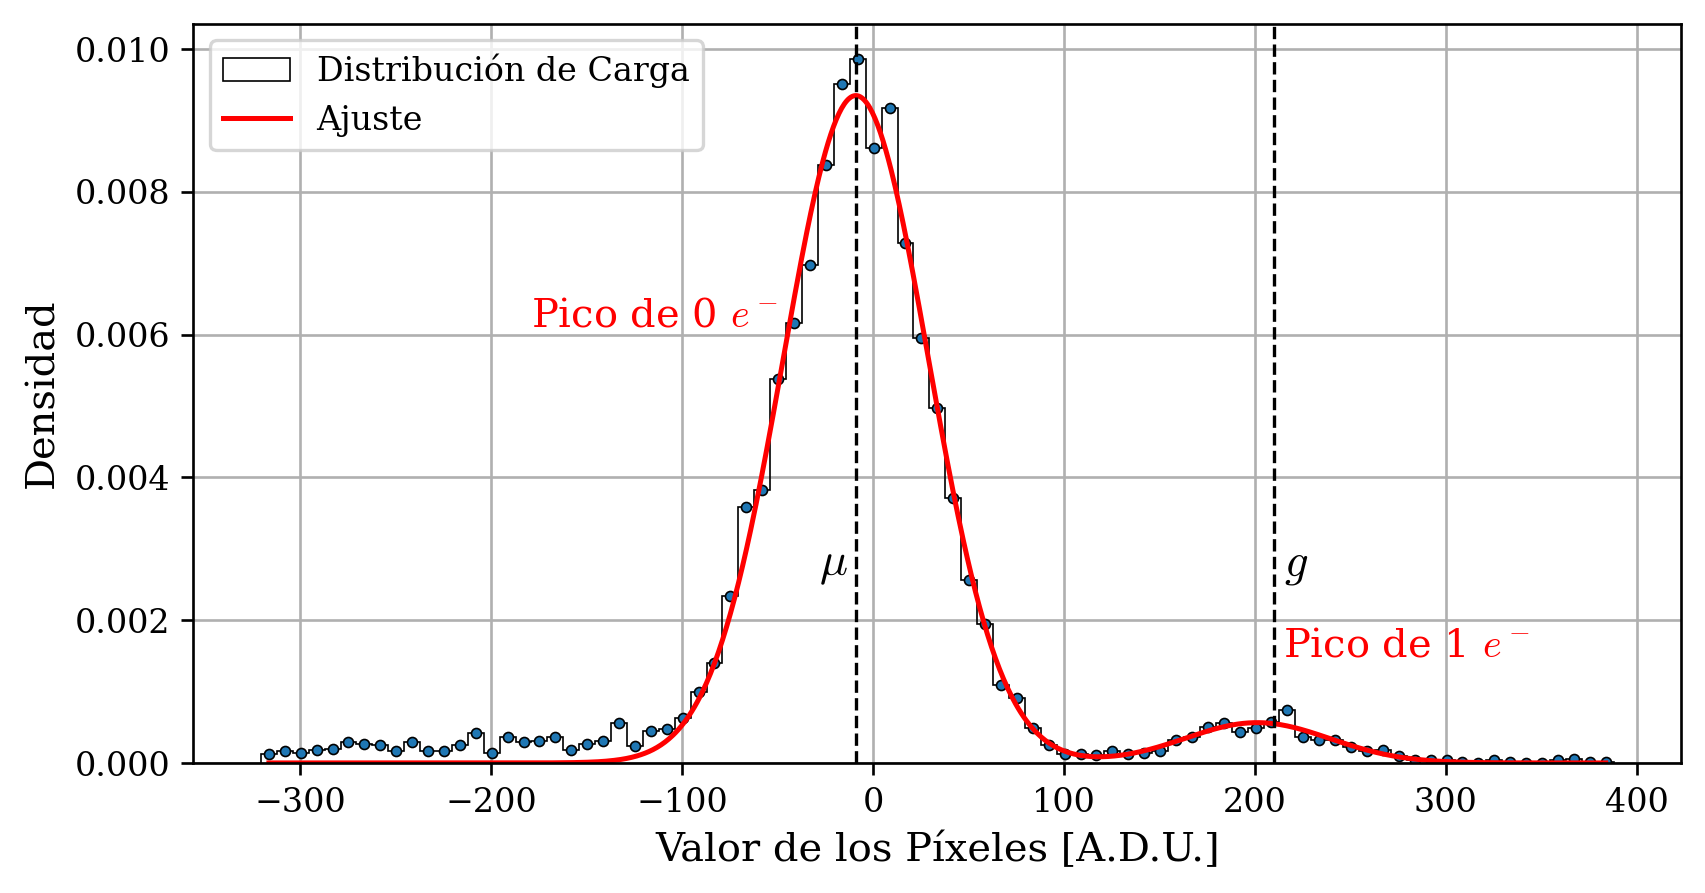

In [112]:

nbins = 85
inf_quantile = 0.01
sup_quantile = 0.995
test_data = test_image[frame_idx].data.flatten()
density, edges = np.histogram(
    test_data[
        (test_data > np.quantile(test_data, inf_quantile))
        & (test_data < np.quantile(test_data, sup_quantile))
    ],
    bins=nbins,
    density=True,
)
vals = edges[:-1] + np.diff(edges)/2
vals_dense = np.linspace(vals[0], vals[-1], 1_000)
popt, pcov = curve_fit(
    suma_gaussianas, vals, density, p0=[350, 25, 200, 0, 50]
)

fig = plt.figure(figsize=(8, 4))
plt.hist(
    test_data[
        (test_data > np.quantile(test_data, inf_quantile))
        & (test_data < np.quantile(test_data, sup_quantile))
    ],
    bins=nbins,
    density=True,
    histtype="step",
    color="k",
    lw=0.5,
    label="Distribución de Carga"
)


plt.plot(vals, density, ".", mec="k", mew=0.5)
plt.plot(vals_dense, suma_gaussianas(vals_dense, *popt), "-r", lw=1.5,
         label="Ajuste")

plt.axvline(popt[-2], ls="--", lw=1, color="k")
plt.text(popt[-2]*1.5, np.max(density)/4, r"$\mu$", ha="right", va="bottom", fontsize="14")
plt.text(-50, 0.006, r"Pico de 0 $e^-$", color="r", ha="right", va="bottom", fontsize=12)

plt.axvline(popt[-3], ls="--", lw=1, color="k")
plt.text(popt[-3]*1.025, np.max(density)/4, r"$g$", ha="left", va="bottom", fontsize="14")
plt.text(215, 0.0019, r"Pico de 1 $e^-$", color="r", ha="left", va="top", fontsize=12)

plt.grid()
plt.legend()
plt.xlabel("Valor de los Píxeles [A.D.U.]")
plt.ylabel("Densidad")
plt.show()